<a href="https://colab.research.google.com/github/jgromero/rl_seminar_2023/blob/main/code/cartpole-reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REINFORCE for _cartpole_

[**Juan Gómez Romero**](https://decsai.ugr.es/~jgomez)  
Departamento de Ciencias de la Computación e Inteligencia Artificial  
Universidad de Granada  
This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).

---
Ejemplo basado en:
> Udacity (2019) Deep Reinforcement Learning Course. Disponible en [GitHub](https://github.com/udacity/deep-reinforcement-learning/tree/master/reinforce).

## Configuration

In [1]:
!pip install gymnasium

In [2]:
# check whether in Colab
import sys
render = 'google.colab' in sys.modules
if render:
  render_mode = "rgb_array"
else:
  render_mode = "human"

## Environment

We will be using [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/), a simple control problem.

<img src="https://github.com/jgromero/rl_seminar_2023/blob/main/code/cartpole.gif?raw=true"/>


The action and observation spaces can be printed as follows.

In [3]:
import gymnasium as gym
env = gym.make("CartPole-v1", render_mode = render_mode)
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Discrete(2)
(-inf, inf)


## REINFORCE algorithm
Next we provide a generic implementation of REINFORCE. We do not use external files here. There is no explicit _agent_ object, the capabilities (i.e., act) are encoded along the policy network.

The [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment is solved when the agent obtains more than $195$ points in average for 100 consecutive episodes.

### Imports and initializations

In [9]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode = render_mode)

### Policy definition

In [10]:
class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

### Training loop

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100	Average Score: (last 100): 26.23
Episode 200	Average Score: (last 100): 53.44
Episode 300	Average Score: (last 100): 56.56
Episode 400	Average Score: (last 100): 97.29
Episode 500	Average Score: (last 100): 22.18
Episode 600	Average Score: (last 100): 26.80
Episode 700	Average Score: (last 100): 34.79
Episode 800	Average Score: (last 100): 82.07
Episode 900	Average Score: (last 100): 72.80
Episode 1000	Average Score: (last 100): 91.15
Episode 1100	Average Score: (last 100): 116.45
Episode 1200	Average Score: (last 100): 71.83
Episode 1300	Average Score: (last 100): 137.47
Episode 1400	Average Score: (last 100): 54.31
Episode 1500	Average Score: (last 100): 49.46
Episode 1600	Average Score: (last 100): 62.52
Episode 1700	Average Score: (last 100): 68.61
Episode 1800	Average Score: (last 100): 79.51
Episode 1900	Average Score: (last 100): 189.53
Problem solved in 1805 episodes!	Average Score: last 100): 195.58)


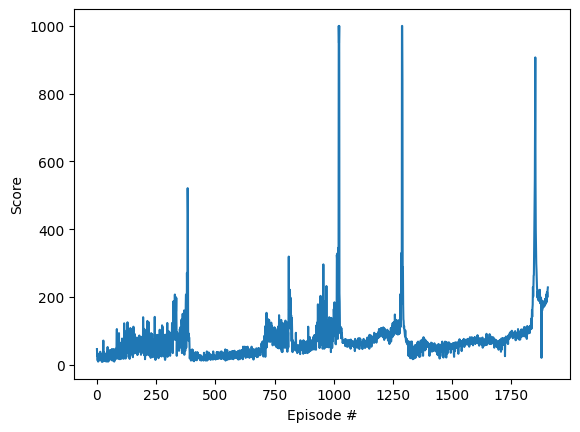

In [14]:
policy = Policy().to(device)

def reinforce(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    """REINFORCE.

    Params
    ======
        policy (Policy): neural network with act method
        n_episodes (int): maximum number of episodes (n_episodes)
        max_t (int): maximum number of steps per episode (n_steps)
        gamma (float): discount factor
        print_every (int): print score each print_every episodes
    """

    scores = []                          # scores for every episode
    scores_window = deque(maxlen=100)    # scores for the last episodes (100 by default)

    optimizer = optim.Adam(policy.parameters(), lr=1e-2)  # optimizer used for training

    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0

        saved_log_probs = []  # action probabilities
        rewards = []          # rewards of the trajectory

        for t in range(max_t):

            # choose action At with the policy network
            action, log_prob = policy.act(state)

            # save actions' probabilities
            saved_log_probs.append(log_prob)

            # apply At and get Rt+1, St+1
            next_state, reward, done, _, _ = env.step(action)

            # store reward
            rewards.append(reward)

            # advance to next state
            state = next_state
            score += reward

            if done:
                break

        scores_window.append(score)       # save last score (last 100 by default)
        scores.append(score)              # save last score (every episode)

        # calculate discounted reward for the episode
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        # train & update
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # print training info
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: (last {:d}): {:.2f}'.format(i_episode, print_every, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
            print('Problem solved in {:d} episodes!\tAverage Score: last {:d}): {:.2f})'.format(i_episode-print_every, print_every, np.mean(scores_window)))
            torch.save(policy.state_dict(), 'checkpoint-cartpole-reinforce.pth') # save weights for trained agent
            break

    return scores

scores = reinforce(policy, n_episodes=5000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Visualize trained agent

We can afterwards load the trained agent and visualize how it acts on the environment. (Local run is required for 2D rendering, not Google Colaboratory.)

In [17]:
# load weights from `checkpoint.pth`
policy_load = Policy()

policy_load.load_state_dict(torch.load('checkpoint-cartpole-reinforce.pth'))

for i in range(3):
    state, _ = env.reset()
    for j in range(200):
        action, _ = policy_load.act(state)
        env.render()
        state, reward, done, _, _ = env.step(action)
        if done:
            break

env.close()